### Import necessary dependencies

In [1]:
import os
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import to_pil_image
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import random
from torchvision.transforms import ToPILImage

torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Defining modcrop function
- Make sure the image's width and height is completely divisible by the scale that we want to downsample the image to.

In [2]:
def modcrop(img, scale):
    h, w = img.shape[1], img.shape[2]  # img = torch.Size([3, H, W])
    h = h - (h % scale)
    w = w - (w % scale)
    img = img[:, :h, :w]
    return img

### Define preprocessing function and function to display the GT and LR version of an image
- Downsample each images in a folder and return a tuple containing the GT and input image

In [3]:
def image_to_patches(image, patch_size):
    channels, height, width = image.size()
    patch_channels, patch_height, patch_width = patch_size
    patches = []

    # Pad the image to ensure its dimensions are divisible by the patch size
    pad_height = patch_height - height % patch_height
    pad_width = patch_width - width % patch_width
    padded_image = F.pad(image, (0, pad_width, 0, pad_height), mode='constant', value=0)

    # Extract patches from the padded image
    for y in range(0, height, patch_height):
        for x in range(0, width, patch_width):
            patch = padded_image[:, y:y+patch_height, x:x+patch_width]
            patches.append(patch)

    return patches

In [4]:
def preprocess_images_in_folder(folder_path, scale, patch_size):
    processed_images = []

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        input_image = Image.open(img_path).convert('RGB')

        # Convert input image to tensor
        GT_tensor = TF.to_tensor(input_image).float()

        # Interpolate GT image to create LR image
        LR_image = TF.resize(input_image, [input_image.size[0] // scale, input_image.size[1] // scale], interpolation=Image.BICUBIC)
        LR_tensor = TF.to_tensor(LR_image).float()

        # Resize LR image to match the size of GT image
        LR_image = TF.resize(LR_image, [GT_tensor.shape[1], GT_tensor.shape[2]], interpolation=Image.BICUBIC)
        LR_tensor = TF.to_tensor(LR_image).float()

        # Divide LR and GT images into patches
        LR_patches = image_to_patches(LR_tensor, patch_size)
        GT_patches = image_to_patches(GT_tensor, patch_size)

        # Append LR and GT patches as a tuple
        processed_images.extend(zip(LR_patches, GT_patches))

    return processed_images

In [5]:
def display_image(LR, GT):
    
    # Display the label image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(GT.permute(1, 2, 0))
    plt.title('Ground Truth (GT)')
    plt.axis('off')
    
    # Display the input image
    plt.subplot(1, 2, 2)
    plt.imshow(LR.permute(1, 2, 0))
    plt.title('Low Resolution (LR)')
    plt.axis('off')

    plt.show()

### Preprocessing training images

In [6]:

train_folder_path = 'data/Train/ILSVRC2013/'
test_set5_folder_path = 'data/Test/Set5/'
test_set14_folder_path = 'data/Test/Set14/'
scale = 3

processed_train_images = preprocess_images_in_folder(train_folder_path, scale, (3, 33,33))
processed_test_set5_images = preprocess_images_in_folder(test_set5_folder_path, scale, (3, 33,33))
processed_test_set14_images = preprocess_images_in_folder(test_set14_folder_path, scale, (3, 33, 33))

### Display random test images from Set5

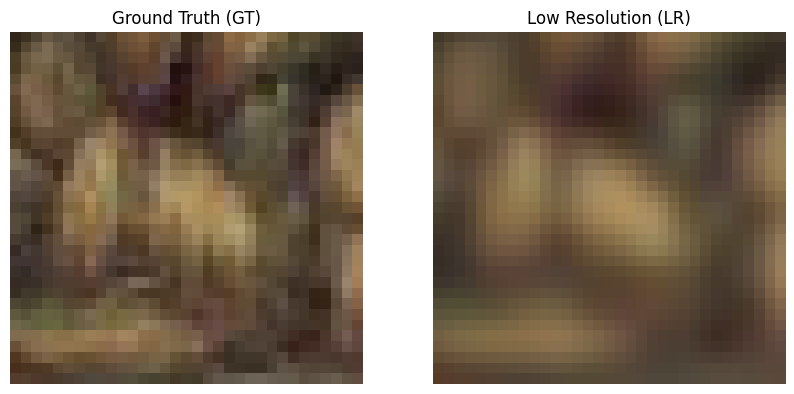

In [7]:
# Select a random image from the preprocessed images
random_image = random.choice(processed_test_set5_images)
LR, GT = random_image

# Display the random image
display_image(LR, GT)

### Putting preprocessed images in DataLoader

In [8]:
train_loader = DataLoader(processed_train_images, batch_size=128)
test_set5_loader = DataLoader(processed_test_set5_images, batch_size=128)
test_set14_loader = DataLoader(processed_test_set14_images, batch_size=128)

### Define SRCNN model architecture

In [9]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4)
        self.relu1 = nn.ReLU(True)
        
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU(True)
        
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=2)
        
    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = self.relu2(self.conv2(out))
        out = self.conv3(out)
        return out

### Settting up hyperparameters

In [12]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False


In [10]:
model = SRCNN()
criterion = nn.SmoothL1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Initialize early stopping
#early_stopping = EarlyStopping(patience=10, min_delta=0.01)

num_epochs = 100
best_model_wts = None
best_loss = float('inf')

In [11]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for LR, GT in train_loader:
        LR, GT = LR.to(device), GT.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(LR)
        
        # Compute loss
        loss = criterion(outputs, GT)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * LR.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss}')
    
    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for LR, GT in test_set5_loader:
            LR, GT = LR.to(device), GT.to(device)
            outputs = model(LR)
            loss = criterion(outputs, GT)
            val_loss += loss.item() * LR.size(0)
    
    val_loss /= len(test_set5_loader.dataset)
    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss Set 5: {val_loss}')
    
    # Step the scheduler based on the validation loss
    #scheduler.step(val_loss)
    
    # Check for early stopping
    """ if early_stopping(val_loss):
        print("Early stopping")
        break """
    
    # Save the best model weights
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = model.state_dict()

print('Training finished.')

# Load the best model weights
model.load_state_dict(best_model_wts)

# Save the best model
torch.save(model.state_dict(), 'super_resolution_model_best.pth')

Epoch [10/100], Training Loss: 0.0028382374976894044
Epoch [10/100], Validation Loss Set 5: 0.0016532349129488996
Epoch [20/100], Training Loss: 0.002562330294524605
Epoch [20/100], Validation Loss Set 5: 0.0013736527457280162
Epoch [30/100], Training Loss: 0.0024051671874127352
Epoch [30/100], Validation Loss Set 5: 0.001209099362404394
Epoch [40/100], Training Loss: 0.0022983350636103005
Epoch [40/100], Validation Loss Set 5: 0.0011051794660256007
Epoch [50/100], Training Loss: 0.002223983157355613
Epoch [50/100], Validation Loss Set 5: 0.0010342833382778922
Epoch [60/100], Training Loss: 0.0021688478932154805
Epoch [60/100], Validation Loss Set 5: 0.0009811598790288039
Epoch [70/100], Training Loss: 0.002125924062508431
Epoch [70/100], Validation Loss Set 5: 0.0009394895278287248
Epoch [80/100], Training Loss: 0.002091737781877432
Epoch [80/100], Validation Loss Set 5: 0.0009060941779426231
Epoch [90/100], Training Loss: 0.002063714998672088
Epoch [90/100], Validation Loss Set 5: 0.

### Training loop

### Visualizing result

In [12]:
# Load the single input image
input_image_path = 'woman_GT.bmp'  # Replace 'input_image.png' with your image path
input_image = Image.open(input_image_path).convert('RGB')

# Convert the image to tensor
input_tensor = TF.to_tensor(input_image).float()  # Change to float

# Assuming scale factor is 3 (adjust if different)
scale = 3

# Process image for GT (ground truth) and LR (low resolution)
GT_image = input_tensor
LR_image = TF.resize(GT_image, [GT_image.shape[1] // scale, GT_image.shape[2] // scale], interpolation=Image.BICUBIC)
LR_image = TF.resize(LR_image, [GT_image.shape[1], GT_image.shape[2]], interpolation=Image.BICUBIC)

# Convert LR image to tensor and add batch dimension
LR_tensor = LR_image.unsqueeze(0)

# Move tensor to device (assuming model is trained on GPU)
LR_tensor = LR_tensor.to(device)

# Perform inference
model.eval()
with torch.no_grad():
    SR_tensor = model(LR_tensor)

# Convert SR tensor back to PIL image
SR_image = TF.to_pil_image(SR_tensor.squeeze(0).cpu())

# Save the super-resolved image
output_image_path = 'woman_HR.bmp'
SR_image.save(output_image_path)  # Save the image as 'super_resolved_image.png' or any desired filename


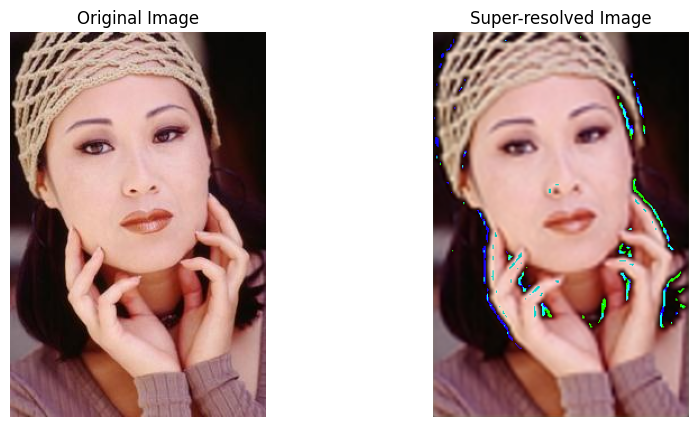

In [13]:
# Load the original and super-resolved images
original_image = Image.open(input_image_path).convert('RGB')  # Load original image
super_resolved_image = Image.open(output_image_path).convert('RGB')  # Load super-resolved image

# Display the images side by side using matplotlib
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Super-resolved image
plt.subplot(1, 2, 2)
plt.imshow(super_resolved_image)
plt.title('Super-resolved Image')
plt.axis('off')

plt.show()
